In [228]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import difflib
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import OneHotEncoder

In [273]:
import_df = pd.read_csv('../datasets/all_merged.csv').drop(columns=['Marital.Status'])
import_df.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Position.on.Federal.K.12.Education.Policy,Position.on.Climate.Change,Position.on.Campaign.Finance.Reform,Position.on.Legalization.Decriminalization.of.Marijuana.Policy,Position.on.Defense.Spending,Position.on.Handling.Terrorism.Abroad,Position.on.Russia,Party.Category,Female,SinglePayer
0,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,0,None,None,-30.680000,...,Candidate supports federal proposals for major...,Candidate supports regulations and measures to...,Candidate provides no information,Candidate supports legalization/decriminalizat...,Candidate provides no information,Candidate provides no information,Candidate provides no information,Establishment Democrat,1.0,0
1,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,1,None,On the Ballot,-30.680000,...,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Establishment Democrat,0.0,0
2,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,0,None,None,-33.080002,...,Candidate supports federal proposals for major...,Candidate supports regulations and measures to...,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Progressive Democrat,1.0,1
3,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,1,None,On the Ballot,-33.080002,...,Candidate supports federal proposals for major...,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate opposes reductions in military spending,Candidate provides no information,Candidate provides no information,Progressive Democrat,1.0,1
4,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,0,None,None,-33.660000,...,Candidate supports federal proposals for major...,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Candidate provides no information,Other,1.0,0


In [280]:
cat_cols = ['Education', 'Position.on.Affordable.Care.Act..ObamaCare.', 
           'Position.on.Minimum.Wage', 'Position.on.Federal.Taxes', 'Position.on.Business.Regulations', 
           'Position.on.National.Debt.Deficit', 'Position.on.Social.Security', 'Position.on.Gun.Control', 
           'Position.on.Immigration', 'Position.on.Abortion', 'Position.on.Criminal.Justice.Reform', 
           'Position.on.Federal.K.12.Education.Policy', 'Position.on.Climate.Change', 'Position.on.Campaign.Finance.Reform', 
           'Position.on.Legalization.Decriminalization.of.Marijuana.Policy', 'Position.on.Defense.Spending', 
           'Position.on.Handling.Terrorism.Abroad', 'Position.on.Russia', 'Party.Category']

enc = OneHotEncoder()
enc.fit(import_df[cat_cols])

cat_df = pd.DataFrame(data=enc.transform(import_df[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))
cat_df = cat_df.drop(columns=[s for s in cat_df.columns if 'Candidate provides no information' in s] + 
                     ["Education_Associate's or less", "Party.Category_Other"])

df = pd.concat([import_df.drop(columns=cat_cols), cat_df], axis=1)
df.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Position.on.Defense.Spending_Candidate supports a reduction in military spending,Position.on.Handling.Terrorism.Abroad_Candidate provides complicated/complex/unclear position,Position.on.Handling.Terrorism.Abroad_Candidate supports calls for increased American intervention to combat terrorism,Position.on.Handling.Terrorism.Abroad_Candidate supports status quo efforts to combat terrorism,Position.on.Russia_Candidate identifies Russia as political ally of the United States,Position.on.Russia_Candidate notes Russia as political enemy of the United States,Position.on.Russia_Candidate provides complicated/complex/unclear position,Party.Category_Establishment Democrat,Party.Category_Moderate Democrat,Party.Category_Progressive Democrat
0,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,0,None,None,-30.680000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,1,None,On the Ballot,-30.680000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,0,None,None,-33.080002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,1,None,On the Ballot,-33.080002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,0,None,None,-33.660000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
endorsement_cols = ['Party Support?', 'Emily Endorsed?', 'Gun Sense Candidate?', 'Biden Endorsed?', 
                    'Warren Endorsed?', 'Sanders Endorsed?', 'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 
                    'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?']

## Functions

In [389]:
def ipw(treatment):
    endorsements = endorsement_cols.copy()
    endorsements.remove(treatment)
    output = df[df[treatment].notnull() == True].reset_index().drop(columns=['index', 'Candidate', 'State', 'District', 'total_runners', 
                                                                            'Office Type', 'Race Type', 'Race Primary Election Date', 
                                                                            'Primary Status', 'Primary Runoff Status', 'General Status', 
                                                                            'Primary %', 'Elected Official?', 'Self-Funder?', 'Obama Alum?', 
                                                                            'Endorsed'] + endorsements).dropna()
    output['Total Other Endorsements'] = output['Total Endorsements'] - output[treatment]
    output = output.drop(columns=['Total Endorsements'])[output['receipts'].notnull()]
    return output

In [390]:
# function for estimating treatment effect
def estimate_treatment_effect(model, X, Y, Z):
    return np.mean((Z * Y / model.predict_proba(X)[:, 1]) - ((1 - Z) * Y / model.predict_proba(X)[:, 0]))

## Inverse Propensity Weighting: Party Support
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Party Support?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [391]:
party = ipw('Party Support?')

# creating our treatment, outcome, and confounder arrays
Z = party['Party Support?'].values
Y = party['Won Primary'].values
X = party.drop(['Party Support?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.2285339007783143

In [392]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.9014184397163121

### Adding the propensity scores

In [393]:
party['pscore'] = fit.predict_proba(X)[:, 1]
party.head()

,Partisan Lean,Won Primary,Race,LGBTQ?,STEM?,Party Support?,receipts,Listed.military.service.,Previous.Electoral.Experience,Position.on.Same.Sex.Marriage,...,Position.on.Handling.Terrorism.Abroad_Candidate supports calls for increased American intervention to combat terrorism,Position.on.Handling.Terrorism.Abroad_Candidate supports status quo efforts to combat terrorism,Position.on.Russia_Candidate identifies Russia as political ally of the United States,Position.on.Russia_Candidate notes Russia as political enemy of the United States,Position.on.Russia_Candidate provides complicated/complex/unclear position,Party.Category_Establishment Democrat,Party.Category_Moderate Democrat,Party.Category_Progressive Democrat,Total Other Endorsements,pscore
0,-13.51,1,0,0,0,1.0,2366991.03,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.634807
1,-13.51,0,0,0,0,0.0,33934.76,1,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.501982
2,-13.51,0,1,0,0,0.0,34466.05,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.502013
3,-13.51,0,0,0,0,0.0,270092.89,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.515767
4,0.62,0,0,0,1,0.0,68767.16,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.504016


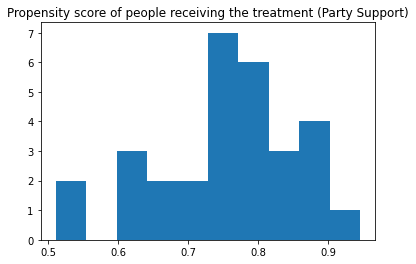

In [394]:
plt.hist(party[party['Party Support?'] == 1]['pscore']);
plt.title("Propensity score of people receiving the treatment (Party Support)")
plt.savefig('party_support_treat.png');

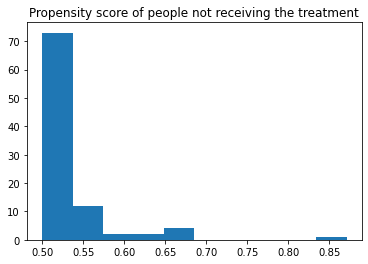

In [395]:
plt.hist(party[party['Party Support?'] == 0]['pscore']);
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('party_support_ctrl.png');

### IPW Estimate

In [396]:
reweighted_treated = (party[party['Party Support?'] == 1]['Won Primary'] / party[party['Party Support?'] == 1]['pscore']).sum()
reweighted_control = (party[party['Party Support?'] == 0]['Won Primary'] / (1 - party[party['Party Support?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(party)
print('IPW estimate:', ipw_estimate)

obs_filt = party[party['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Party Support?'] == 1]['Won Primary'] / obs_filt[obs_filt['Party Support?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Party Support?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Party Support?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.22853390077831423
trimmed IPW estimate: 0.22179853142681802


## Inverse Propensity Weighting: Our Revolution
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Our Revolution Endorsed?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [397]:
our_rev = ipw('Our Revolution Endorsed?')

In [398]:
# creating our treatment, outcome, and confounder arrays
Z = our_rev['Our Revolution Endorsed?'].values
Y = our_rev['Won Primary'].values
X = our_rev.drop(['Our Revolution Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.10458940119775088

Since this is a negative number, the treatment (being endorsed by `Our Revolution`) caused the probability of winning to decrease.

In [399]:
# naive estimator from HW4, not sure if we need for this
# the naive estimator does not account for confounders!
# Interesting... once we control for confounders, we observe the opposite effect (positive to negative)
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.08968678380443085

### Adding the propensity scores

In [400]:
our_rev['pscore'] = fit.predict_proba(X)[:, 1]
our_rev.head()

,Partisan Lean,Won Primary,Race,LGBTQ?,STEM?,Our Revolution Endorsed?,receipts,Listed.military.service.,Previous.Electoral.Experience,Position.on.Same.Sex.Marriage,...,Position.on.Handling.Terrorism.Abroad_Candidate supports calls for increased American intervention to combat terrorism,Position.on.Handling.Terrorism.Abroad_Candidate supports status quo efforts to combat terrorism,Position.on.Russia_Candidate identifies Russia as political ally of the United States,Position.on.Russia_Candidate notes Russia as political enemy of the United States,Position.on.Russia_Candidate provides complicated/complex/unclear position,Party.Category_Establishment Democrat,Party.Category_Moderate Democrat,Party.Category_Progressive Democrat,Total Other Endorsements,pscore
0,-21.379999,1,0,0,0,1.0,1097584.95,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.374233
1,-21.379999,0,0,0,0,0.0,17275.00,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497977
2,-21.379999,0,0,0,0,0.0,290020.57,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.466091
3,-21.379999,0,0,0,0,0.0,68655.53,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.491961
4,0.620000,0,0,0,1,1.0,68767.16,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.491948


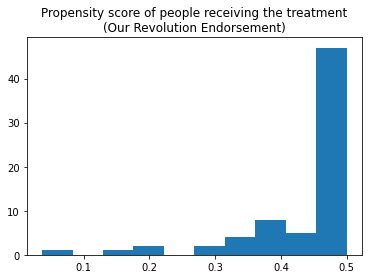

In [401]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Our Revolution Endorsement)")
plt.savefig('our_rev_treat.png');

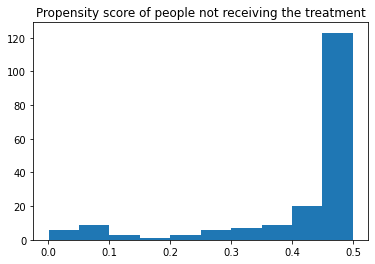

In [402]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('our_rev_ctrl.png');

### IPW Estimate

In [403]:
reweighted_treated = (our_rev[our_rev['Our Revolution Endorsed?'] == 1]['Won Primary'] / our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (our_rev[our_rev['Our Revolution Endorsed?'] == 0]['Won Primary'] / (1 - our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(our_rev)
print('IPW estimate:', ipw_estimate)

obs_filt = our_rev[our_rev['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.10458940119775081
trimmed IPW estimate: 0.06421414372228297


## Inverse Propensity Weighting: Emily's List
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Emily Endorsed?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [404]:
emily = ipw('Emily Endorsed?')

In [405]:
# creating our treatment, outcome, and confounder arrays
Z = emily['Emily Endorsed?'].values
Y = emily['Won Primary'].values
X = emily.drop(['Emily Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.2019551524728514

In [406]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.6101842196732707

### Adding the propensity scores

In [407]:
emily['pscore'] = fit.predict_proba(X)[:, 1]
emily.head()

,Partisan Lean,Won Primary,Race,LGBTQ?,STEM?,Emily Endorsed?,receipts,Listed.military.service.,Previous.Electoral.Experience,Position.on.Same.Sex.Marriage,...,Position.on.Handling.Terrorism.Abroad_Candidate supports calls for increased American intervention to combat terrorism,Position.on.Handling.Terrorism.Abroad_Candidate supports status quo efforts to combat terrorism,Position.on.Russia_Candidate identifies Russia as political ally of the United States,Position.on.Russia_Candidate notes Russia as political enemy of the United States,Position.on.Russia_Candidate provides complicated/complex/unclear position,Party.Category_Establishment Democrat,Party.Category_Moderate Democrat,Party.Category_Progressive Democrat,Total Other Endorsements,pscore
0,0.62,0,0,0,1,0.0,68767.16,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.499988
1,0.62,1,0,0,1,0.0,8441529.09,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.498499
2,0.62,0,0,0,0,0.0,346820.52,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.499938
3,0.62,0,0,0,1,0.0,48734.30,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.499991
4,0.62,0,0,0,1,0.0,840266.61,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.499851


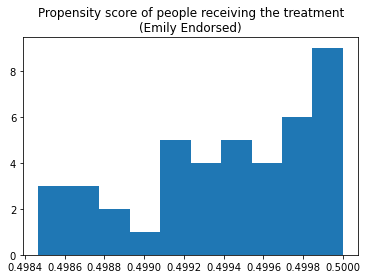

In [408]:
plt.hist(emily[emily['Emily Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Emily Endorsed)")
plt.savefig('emily_treat.png');

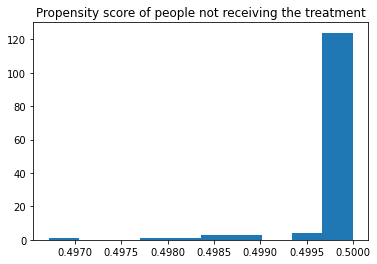

In [409]:
plt.hist(emily[emily['Emily Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('emily_ctrl.png');

### IPW Estimate

In [410]:
reweighted_treated = (emily[emily['Emily Endorsed?'] == 1]['Won Primary'] / emily[emily['Emily Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (emily[emily['Emily Endorsed?'] == 0]['Won Primary'] / (1 - emily[emily['Emily Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(emily)
print('IPW estimate:', ipw_estimate)

obs_filt = emily[emily['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Emily Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Emily Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Emily Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Emily Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.20195515247285142
trimmed IPW estimate: 0.20195515247285142


## Inverse Propensity Weighting: Justice Dems
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Justice Dems Endorsed?'`
- X (confounders): `'Total Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [411]:
jd = ipw('Justice Dems Endorsed?')

In [412]:
# creating our treatment, outcome, and confounder arrays
Z = jd['Justice Dems Endorsed?'].values
Y = jd['Won Primary'].values
X = jd.drop(['Justice Dems Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.11729285687927478

In [413]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.043893129770992356

### Adding the propensity scores

In [414]:
jd['pscore'] = fit.predict_proba(X)[:, 1]
jd.head()

,Partisan Lean,Won Primary,Race,LGBTQ?,STEM?,Justice Dems Endorsed?,receipts,Listed.military.service.,Previous.Electoral.Experience,Position.on.Same.Sex.Marriage,...,Position.on.Handling.Terrorism.Abroad_Candidate supports calls for increased American intervention to combat terrorism,Position.on.Handling.Terrorism.Abroad_Candidate supports status quo efforts to combat terrorism,Position.on.Russia_Candidate identifies Russia as political ally of the United States,Position.on.Russia_Candidate notes Russia as political enemy of the United States,Position.on.Russia_Candidate provides complicated/complex/unclear position,Party.Category_Establishment Democrat,Party.Category_Moderate Democrat,Party.Category_Progressive Democrat,Total Other Endorsements,pscore
0,-21.379999,1,0,0,0,1.0,1097584.95,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.310410
1,-21.379999,0,0,0,0,0.0,17275.00,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496859
2,-21.379999,0,0,0,0,0.0,290020.57,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.447466
3,-21.379999,0,0,0,0,0.0,68655.53,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.487520
4,0.620000,0,0,0,1,1.0,68767.16,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.487500


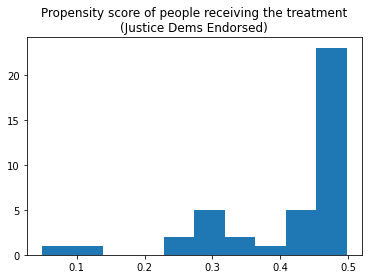

In [415]:
plt.hist(jd[jd['Justice Dems Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Justice Dems Endorsed)")
plt.savefig('justice_dems_treat.png');

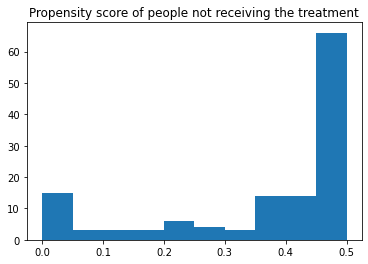

In [416]:
plt.hist(jd[jd['Justice Dems Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('justice_dems_ctrl.png');

### IPW Estimate

In [417]:
reweighted_treated = (jd[jd['Justice Dems Endorsed?'] == 1]['Won Primary'] / jd[jd['Justice Dems Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (jd[jd['Justice Dems Endorsed?'] == 0]['Won Primary'] / (1 - jd[jd['Justice Dems Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(jd)
print('IPW estimate:', ipw_estimate)

obs_filt = jd[jd['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Justice Dems Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Justice Dems Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Justice Dems Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Justice Dems Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.11729285687927486
trimmed IPW estimate: 0.11231699005167115


## Inverse Propensity Weighting: Gun Sense
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Gun Sense Candidate?'`
- X (confounders): `'Total Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [418]:
gs = ipw('Gun Sense Candidate?')

In [419]:
# creating our treatment, outcome, and confounder arrays
Z = gs['Gun Sense Candidate?'].values
Y = gs['Won Primary'].values
X = gs.drop(['Gun Sense Candidate?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.1324367003660813

In [420]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.3180127148575465

### Adding the propensity scores


In [421]:
gs['pscore'] = fit.predict_proba(X)[:, 1]
gs.head()

,Partisan Lean,Won Primary,Race,LGBTQ?,STEM?,Gun Sense Candidate?,receipts,Listed.military.service.,Previous.Electoral.Experience,Position.on.Same.Sex.Marriage,...,Position.on.Handling.Terrorism.Abroad_Candidate supports calls for increased American intervention to combat terrorism,Position.on.Handling.Terrorism.Abroad_Candidate supports status quo efforts to combat terrorism,Position.on.Russia_Candidate identifies Russia as political ally of the United States,Position.on.Russia_Candidate notes Russia as political enemy of the United States,Position.on.Russia_Candidate provides complicated/complex/unclear position,Party.Category_Establishment Democrat,Party.Category_Moderate Democrat,Party.Category_Progressive Democrat,Total Other Endorsements,pscore
0,-33.66,0,1,0,1,1.0,14535.25,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501378
1,-33.66,1,0,0,0,1.0,467514.71,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.544193
2,-62.48,1,0,0,0,1.0,70425.87,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.506674
3,-62.48,0,0,0,0,0.0,21088.35,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.501999
4,-13.51,1,0,0,0,1.0,2366991.03,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.710401


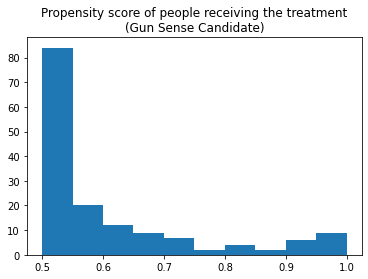

In [422]:
plt.hist(gs[gs['Gun Sense Candidate?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Gun Sense Candidate)")
plt.savefig('gun_sense_treat.png');

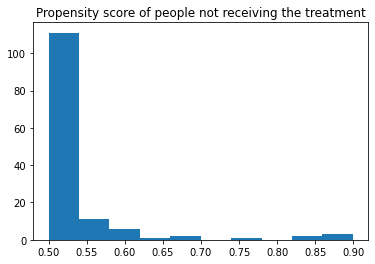

In [423]:
plt.hist(gs[gs['Gun Sense Candidate?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('gun_sense_ctrl.png');

### IPW Estimate

In [424]:
reweighted_treated = (gs[gs['Gun Sense Candidate?'] == 1]['Won Primary'] / gs[gs['Gun Sense Candidate?'] == 1]['pscore']).sum()
reweighted_control = (gs[gs['Gun Sense Candidate?'] == 0]['Won Primary'] / (1 - gs[gs['Gun Sense Candidate?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(gs)
print('IPW estimate:', ipw_estimate)

obs_filt = gs[gs['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Gun Sense Candidate?'] == 1]['Won Primary'] / obs_filt[obs_filt['Gun Sense Candidate?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Gun Sense Candidate?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Gun Sense Candidate?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.1324367003660813
trimmed IPW estimate: 0.08270524718717327


## Bootstrapping ATE estimates

In [427]:
def draw_tau_hat(data, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(frac=1, replace=True, random_state=random_state)
    fit_model = fit_OLS_model(sample, 'outcome', ['treat', 'age', 'educ', 'black', 'hisp', 'marr', 'nodegree'])
    estimated_ate = fit_model.params['treat']
    return estimated_ate

def get_bootstrapped_ate(data, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(data))
    return estimates